<h1 align = 'center'> 
    Machine learning against pollution: clustering analysis of Greater Mexico City's venues and air quality 
</h1>

<h4 align = 'center'>
    A. Payen-Sandoval
</h4>

In this notebook, we will inspect the possible relationships between air quality (measured in the IMECA unit) and the types and amounts of venues in a 2km radius around air quality measuring stations, spread across Greater Mexico City (GMX).

## Table of contents
* [0. Introduction](#introduction)
* [1. Required libraries](#libraries)
* [2.a Data: air quality](#data_air)
* [2.b Data: venues](#data_venues)
* [2.c Data: joining the pieces together](#data_join)
* [3 Exploratory analysis of the data](#exploration)
* [4. Clustering](#methodology_clustering)
* [5. Results and discussion](#results)
* [6. Conclusion](#conclusion)
* [7. Final remarks](#remarks)

<hr>
<h1 align='center'> 0. Introduction </h1> <a name="introduction"></a>
<hr>

Greater Mexico City (GMX), which comprises Mexico City and the east half of the surrounding State of Mexico, is one of the largest, most populated regions in the world, housing over 20 million people (Borbet 2018). In 1992, GMX was considered the most polluted urban area in the world (Campbell 2016). It got much better, for some years, but around 2016, pollution notoriously started coming back (Schachar 2018). Since then, multiple measures have been implemented, from strict regulation of vehicle traffic to outright recommending people not to go out during certain times of day, when pollution reaches its peak values. These measures are not enough, however, and pollution is taking its toll on public health and the economy. 

GMX is an interesting candidate to study pollution: it contains heavily urbanized areas, rural areas, mountains, lakes, basins and, of course, an immense amount and diversity of venues. In GMX, The IMECA ('metropolitan index for air quality', by its spanish meaning) is a standarized unit used to measure multiple pollutants. Being a dimensionless unit, it provides easy understanding of its meaning to the general population, and allows direct comparison between pollutants. 

The goal of this work is to analyze the influence that different types and amounts of venues can have on the IMECA values of carbon monoxide (CO), ozone (O<sub>3</sub>), nitrogen dioxide (NO<sub>2</sub>), sulfur dioxide (SO<sub>2</sub>), particulate matter with less than 10 micrometers in diameter (PM10) and particulate matter with less than 2.5 micrometers in diameter (PM25), in the vicinity of air quality measuring stations spread across GMX. 

This and future studies of the same type could be used by governments and private institutions to measure the impact of building or adapting new venues and avoid future environmental contingencies. 

<hr>
<h1 align='center'> 1. Required libraries </h1> <a name="libraries"></a>
<hr>

We first install and import any libraries that we need. 

In [1]:
!python3 -m pip install lxml
!python3 -m pip install cssselect
!python3 -m pip install folium

You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%matplotlib inline

from folium.features import DivIcon
import requests, json, random
import folium
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from pandas.io.json import json_normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lxml.html import parse
import lxml.html as lh
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

<hr>
<h1 align='center'> 2.a Data: air quality </h1> <a name="data_air"></a>
<hr>

The air quality data is split into six files: one for carbon monoxide (CO), nitrogen dioxide (NO<sub>2</sub>), ozone (O<sub>3</sub>), sulfur dioxide (SO<sub>2</sub>), particulate matter less than 10 micrometers in diameter (PM10) and particulate matter less than 2.5 micrometers in diameter (PM25).

Let's read the data files and see their contents:

In [3]:
molecules = ['CO', 'NO2', 'O3', 'SO2', 'PM10', 'PM25'] 
dfs = np.zeros(len(molecules), dtype = object) # creating an array for dataframes
 
for i, molecule in enumerate(molecules):
    dfs[i] = pd.read_csv(molecule + '.csv', delimiter=',')

This is what the NO<sub>2</sub> file looks like:

In [4]:
dfs[1].head()

,FECHA,HORA,ACO,AJM,ATI,BJU,CAM,CCA,CHO,COY,...,SAG,SFE,SJA,TAH,TLA,TLI,UAX,UIZ,VIF,XAL
0,2019-01-01,1,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
1,2019-01-01,2,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
2,2019-01-01,3,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
3,2019-01-01,4,-99,1,15,15,17,15,13,-99,...,15,7,-99,11,14,-99,14,16,18,17
4,2019-01-01,5,-99,1,12,15,16,13,12,-99,...,14,6,-99,7,14,-99,14,16,16,16


The fist and second columns are the date and hour in which measurements were taken. The next columns correspond to the codenames of the stations. We will see more of these codes in section 2, when we prepare the venue data. Let's see in which months pollution is highest, so that we can choose an appropriate range of time to analyze:

In [5]:
for df, mol in zip(dfs, molecules):
    proxy = df.drop(columns = ['FECHA', 'HORA'])
    max_pollution = proxy.values.max()
    max_pol_col = proxy.max().idxmax()
    max_pol_row = proxy[max_pol_col].idxmax()
    
    print(mol, '-->', max_pol_col, df.loc[max_pol_row, 'FECHA'], max_pollution)

CO --> TLA 2019-02-15 25
NO2 --> CAM 2019-01-07 52
O3 --> CAM 2019-03-30 155
SO2 --> TLI 2019-12-19 68
PM10 --> VIF 2019-01-01 166
PM25 --> NEZ 2019-01-01 185


From last year, the winter months (plus march) were the most polluted. We will take the data from january to march of 2019, and december of 2019.

In [6]:
def format_dataframe(df):
    
    df = df.loc[df['FECHA'].str.contains('-01-') | df['FECHA'].str.contains('-02-') | 
           df['FECHA'].str.contains('-03-') | df['FECHA'].str.contains('-12-')].copy()
    df = df.drop(columns = ['FECHA', 'HORA'])
    
    for col in df.columns[2:]:
        df.loc[:, col] = pd.to_numeric(df[col], errors = 'coerce')

    return df.copy()

In [7]:
for i, frame in enumerate(dfs):
    dfs[i] = format_dataframe(frame)

In [8]:
dfs[1].head()

,ACO,AJM,ATI,BJU,CAM,CCA,CHO,COY,CUA,CUT,...,SAG,SFE,SJA,TAH,TLA,TLI,UAX,UIZ,VIF,XAL
0,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
1,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
2,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
3,-99,1,15,15,17,15,13,-99,14,9,...,15,7,-99,11,14,-99,14,16,18,17
4,-99,1,12,15,16,13,12,-99,16,8,...,14,6,-99,7,14,-99,14,16,16,16


Now we see some columns with -99, such as "ACO", "AJM", etc. This is the case for every dataframe. We should maybe get rid of those columns, but first, we should count the proportion of -99 values per column. We're going to save any column with at least 66% of useful data.

In [9]:
def filter_empty(df):
    length = df.shape[0]
    valid_columns = []

    for col in df.columns.values:
        series = df[col] == -99
        counts = series.value_counts()
        ratio = (counts.values * np.array(counts.index).astype(int)).sum()/length
        if ratio < 0.34:
            valid_columns.append(col) # getting the names of columns with >66% fullness

    return df[valid_columns].copy()

In [10]:
for i, frame in enumerate(dfs):
    dfs[i] = filter_empty(frame)

In [11]:
max_stations = 0
for frame in dfs:
    cols = frame.shape[1]
    if cols > max_stations:
        max_stations = cols # we count the total number of surviving stations
        stations_set = frame.columns.values

We will now take a big leap: averaging every column, for each dataframe, separately. This will give us a seasonal average of each pollutant, at each station. The averages will be stored in a new dataframe, along their respective stations.

In [12]:
cd = np.zeros((max_stations, len(molecules))) 

for j, molecule in enumerate(molecules): #for each molecule
    current = dfs[j]
    for i, col in enumerate(stations_set):
        if col in current.columns:       #check if columns from the big set are in subset
            cd[i, j] = current.loc[:, col].replace(-99, np.nan).mean()
    
cd = pd.DataFrame(data = cd)
cd.columns = molecules
cd.index = stations_set

cd = cd.replace(0, np.nan)
stations_set = frame.columns.values

print(cd.shape)
cd.head()

(26, 6)


,CO,NO2,O3,SO2,PM10,PM25
AJM,2.957509,7.826194,29.899060,5.377872,48.423798,61.818256
ATI,3.788774,11.174881,18.627983,6.873116,61.458678,NaN
BJU,4.624619,NaN,21.430937,NaN,NaN,NaN
CCA,3.840015,11.999284,22.680272,4.214862,NaN,63.772226
CHO,4.696246,9.789322,18.401833,1.866947,NaN,NaN


Our data doesn't look that promising. There are a lot of stations that haven't been working (apparently), and thus, we have missing data. To mitigate some of this, let's fill the NaNs with the means of their respective columns, and add some noise so the clustering algorithm doesn't group those stations together instantly.

In [13]:
for i, col in enumerate(molecules):
    column_data = cd[col]
    mean = column_data.mean()
    maxi = column_data.max()
    for j, row in enumerate(cd.index.values):
        if np.isnan(cd.loc[row, col]):
            random.seed(j)
            noise = random.uniform(-1.0, 1.0) * random.uniform(0.0, maxi - mean)
            cd.loc[row, col] = mean + noise

cd.head()

,CO,NO2,O3,SO2,PM10,PM25
AJM,2.957509,7.826194,29.899060,5.377872,48.423798,61.818256
ATI,3.788774,11.174881,18.627983,6.873116,61.458678,62.950649
BJU,4.624619,16.542634,21.430937,10.964558,96.108170,79.460323
CCA,3.840015,11.999284,22.680272,4.214862,57.399327,63.772226
CHO,4.696246,9.789322,18.401833,1.866947,65.168476,69.238241


We haven't normalized yet, but we will, once the dataset is complete. As things are, most of our data is in inconsistent units (some in parts per million (ppm), some in parts per billion (ppb) and others in micrograms per cubic meter (ug/m^3).

<hr>
<h1 align='center'> 2.b Data: venues </h1> <a name="data_venues"></a>
<hr>

We will now obtain the coordinates for each station from the Dirección de Monitoreo Atmosférico (Athmospheric Monitoring Direction, url: http://www.aire.cdmx.gob.mx/default.php?opc=%27ZaBhnmI=&dc=%27ZA==)

In [14]:
def scrape_table(url, length, level):
    req = requests.get(url)
    doc = lh.fromstring(req.content)
    tr_elements = doc.xpath('//tr')
    col=[] # Create empty list
    
    for t in tr_elements[level]:  # create header of the table
        name = t.text_content()
        col.append((name.replace("\n",""),[]))
        
    for j in range(level + 1,len(tr_elements)): # populate the table
        raw_row = tr_elements[j]
        row = [clean_string(word.text_content()) for word in raw_row.iterchildren()] # get words in each column
        
        if len(row)!= length: # if the row doesn't have "length" columns, then it isn't part of our table
            break
            
        for i, data in enumerate(row):
            col[i][1].append(data)

    Dict={title:column for (title,column) in col}
    return pd.DataFrame(Dict)

In [15]:
def clean_string(string):
    return string.replace('\t', '').replace('\n', '').replace('\r', '').replace("msnm", '')

Inspecting the url, we see that there is only one table. The column 'Clave' contains short names (or Codes) for the stations, 'Nombre' contains the actual names of the stations, 'Alcaldía o municipio' is where the stations are located, and 'Entidad' is either Mexico City or Estado de Mexico, which is the area around Mexico City. 

In [16]:
deleg = scrape_table('http://www.aire.cdmx.gob.mx/default.php?opc=%27ZaBhnmI=&dc=%27ZA==', 4, 0)
deleg.head()

,Clave,Nombre,Alcaldía o municipio,Entidad
0,ACO,Acolman,Acolman,Estado de México
1,AJU,Ajusco,Tlalpan,CDMX
2,AJM,Ajusco Medio,Tlalpan,CDMX
3,ATI,Atizapán,Atizapán de Zaragoza,Estado de México
4,BJU,Benito Juarez,Benito Juárez,CDMX


We then get the data from the links inside the table above. This will give us the coordinates of each station:

In [17]:
dom = parse('http://www.aire.cdmx.gob.mx/default.php?opc=%27ZaBhnmI=&dc=%27ZA==').getroot()
links = dom.cssselect('a')

latlon = []

for link in links:
    if len(link.text_content()) == 3:
        latlon.append(scrape_table(link.get('href'), 6, 2))

ll = latlon[0]

for i in range(1, len(latlon)):
    ll = ll.append(latlon[i], ignore_index=True)

ll.head()

,Domicilio,Alcaldía o municipio,Estado,Latitud,Longitud,Altitud
0,"Calzada de los Agustinos s/n, Col. Centro, C.P...",Acolman,Estado de México,19.635501,-98.912003,2198
1,"Km 36.5 Carretera Federal México-Cuernavaca, C...",Tlalpan,CDMX,19.154674,-99.162459,2953
2,"Encinos # 41, col. Miguel Hidalgo 4ta sección,...",Tlalpan,CDMX,19.272100,-99.207658,2619
3,"Oceano Pacífico s/n, Col. Lomas Lindas, C.P. 5...",Atizapán de Zaragoza,Estado de México,19.576963,-99.254133,2341
4,"Municipio libre y Uxmal, Col. Santa Cruz Atoya...",Benito Juárez,CDMX,19.371612,-99.158969,2250


From the dataframes, we only need 'Clave', 'Latitud', 'Longitud' and 'Altitud'. Let's drop every other column, join the dataframes, make 'Clave' the index, rename the columns and drop every station without air quality data:

In [18]:
if 'Clave' in deleg.columns:
    deleg = deleg[['Clave']].join(ll[['Latitud', 'Longitud', 'Altitud']])
    deleg.index = deleg['Clave']
    deleg.drop(columns = ['Clave'], inplace= True)

deleg.index.name = None
deleg.rename(columns = {'Latitud': 'Latitude', 'Longitud': 'Longitude', 'Altitud': 'Altitude'}, inplace = True)
deleg.loc['FAR', 'Latitude'] = 19.473692

for col in deleg.columns:
    deleg.loc[:, col] = pd.to_numeric(deleg[col], errors = 'coerce')
    
deleg = deleg.loc[cd.index.values].copy()
    
deleg.head()

,Latitude,Longitude,Altitude
AJM,19.272100,-99.207658,2619
ATI,19.576963,-99.254133,2341
BJU,19.371612,-99.158969,2250
CCA,19.326200,-99.176100,2280
CHO,19.266948,-98.886088,2253


We see that our coordinates dataframe has the same stations as our air quality dataframe. Let's visualize these stations.

In [19]:
# create map of Mexico City (and Estado de Mexico) using latitude and longitude values
latitude = 19.4284700
longitude = -99.1276600

map_mx = folium.Map(location=[latitude, longitude], zoom_start = 10)
    
# add markers to map
for lat, lng, label in zip(deleg['Latitude'], deleg['Longitude'], deleg.index):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.8,
        parse_html=False).add_to(map_mx)  

map_mx

Now we can set up our credentials for the Foursquare API:

In [20]:
CLIENT_ID = 'ALOOBVNM4UKUV3TC31W42DGIRYYUGBX3YL25EIQF5S0XSMFK' # your Foursquare ID
CLIENT_SECRET = 'ZKPJX1KRF0YEEGWHTMLIYBPLJGYPRBE44JBHGSBKL4FRU1XT' # your Foursquare Secret
TOKEN = 'FT0HKS1OFGA4B5N5MZR5C1JE3KSC2XTKOMEVYFZJFWRFJKZN'
VERSION = '20180605' # Foursquare API version

LIMIT = 1000 # limit of number of venues returned by Foursquare API

Define the function to fetch locations near to our stations:

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&oauth_token={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            TOKEN,
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()['response']['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Code', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

For good measure, we will grab every venue from a 500 m radius to a 2000 m radius. The 500 m search yields some venues that do not exist in the 2000 m search, maybe due to some restriction in the API. We can then join both dataframes and drop the duplicates, to prevent overlapping. 

In [22]:
venues0 = getNearbyVenues(names = deleg.index,
                         latitudes = deleg['Latitude'],
                         longitudes = deleg['Longitude'],
                         radius = 500)

In [23]:
venues1 = getNearbyVenues(names = deleg.index,
                         latitudes = deleg['Latitude'],
                         longitudes = deleg['Longitude'],
                         radius = 2000)

Let's drop the duplicate venues. We will do this by comparing the venue name along with its latitude and longitude, as there cannot be two different venues with the same name and coordinates.

In [24]:
venues = venues0.append(venues1)
print(venues.shape)
venues = venues.drop_duplicates(subset = ['Venue', 'Venue Latitude', 'Venue Longitude'], keep = False)
venues = venues.reset_index(drop = True)
print(venues.shape)
venues.head()

(2404, 7)
(2132, 7)


,Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AJM,19.2721,-99.207658,Oxxo,19.274657,-99.209401,Convenience Store
1,AJM,19.2721,-99.207658,Carnitas del Ajusco,19.272523,-99.208687,Mexican Restaurant
2,AJM,19.2721,-99.207658,El Mostachón,19.273790,-99.207150,Taco Place
3,AJM,19.2721,-99.207658,La naranja mecánica,19.273658,-99.207507,Convenience Store
4,AJM,19.2721,-99.207658,Sykaryos Paintball,19.272159,-99.209839,Paintball Field


Dropping duplicates, we got rid of almost 300 venues; however, we still have more than 2000 venues. If we do one-hot encoding, we will have hundreds of dimensions in our data (one per category), and we don't even have a hundred data samples. If we are to cluster this, we need to group our venues in more general categories, and use those categories as our new dimensions. We will group every place to eat under a 'Restaurants & Bars' label, every shop and store under the 'Stores' label, and so on. Sadly, we will do that manually.

In [25]:
categories = np.unique(venues['Venue Category'])
stations = deleg.index.values

stores = ['Store', 'Shop', 'Auto Dealership', 'Bookstore', 'Bakery', 'Market']
restaurants_bars = ['Restaurant', 'Bar', 'Joint', 'Beer', 'Place', 'Botanero', 
                    'Breakfast Spot', 'Food', 'Brewery', 'Tea', 'Cafeteria', 'Buffet']
medical = ['Dentist', 'Dental', 'Doctor', 'Veterinarian']
buildings = ['Building', 'Office']
hotels_hostels = ['Bed & Breakfast', 'Hostel', 'Motel', 'Hotel']
museums_galleries = ['Museum', 'Gallery', 'Exhibit']
plazas = ['Plaza']
farms = ['Farm']
parks_forests = ['Park', 'Forest']
schools = ['University', 'School']
gyms_sports = ['Gym', 'Sports', 'Studio', 'Martial Arts', 'Paintball', 'Go Kart']
stadiums_theaters = ['Stadium', 'Concert Hall', 'Theater']
bus_stations = ['Bus Stop', 'Bus Station']
sports_fields = ['Soccer', 'Golf']
industrial = ['Gas Station', 'Distillery']

venues_list = [stores, restaurants_bars, medical, buildings, hotels_hostels, museums_galleries, plazas, 
         farms, parks_forests, schools, gyms_sports, stadiums_theaters, bus_stations, sports_fields, industrial]
names = ['Stores', 'Restaurants & Bars', 'Medical', 'Buildings & Offices', 'Hotels & Hostels',
        'Museums & Galleries', 'Plazas', 'Farms', 'Parks & Forests', 'Schools', 'Gyms & Sports', 
         'Stadiums & Theaters', 'Bus Stations', 'Sports Fields', 'Industrial']

skull = np.zeros((len(stations) + 1, len(venues_list) + 1), dtype=object)
skull[0, 0] = 'Code'
skull[0, 1:] = names
skull[1:, 0] = stations

for i, station in enumerate(stations):
    venues_in_station = venues[venues['Code'] == station]
    for j, type_of_venue in enumerate(venues_list):
        count = 0
        for k, specific_venue in enumerate(type_of_venue):
            a = venues_in_station[venues_in_station['Venue Category'].str.contains(specific_venue)]
            count += a['Venue Category'].count()
        skull[i + 1, j + 1] = count    

In [26]:
mx = pd.DataFrame(skull[1:, 1:])
mx.index = skull[1:, 0]
mx.columns = skull[0, 1:]
mx.loc['XAL', 'Industrial'] += 1 # accounting for soap factory in XAL, missregistered in foursquare as a lounge

mx.head()

,Stores,Restaurants & Bars,Medical,Buildings & Offices,Hotels & Hostels,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,7,28,0,1,0,0,0,0,1,0,4,0,0,0,0
ATI,5,22,0,1,0,0,0,0,2,0,4,0,0,2,0
BJU,49,54,0,3,1,2,0,0,4,0,13,8,0,4,0
CCA,9,61,0,0,0,2,1,0,3,2,9,7,2,1,0
CHO,6,29,0,1,0,0,0,0,0,0,3,0,0,0,0


In [27]:
print(venues.shape)
print(mx.shape)

(2132, 7)
(26, 15)


We've reduced our dimensions from a possible few hundred to 15.

<hr>
<h1 align='center'> 2.c Data: joining the pieces together </h1> <a name="data_join"></a>
<hr>

Let's add the altitude to this dataframe, mx, and join it with the air quality dataframe, cd:

In [28]:
if not ('Altitude' in mx.columns): 
    mx.insert(0, 'Altitude', deleg['Altitude'])
cdmx = cd.join(mx)
cdmx = cdmx.dropna()
cdmx.head()

,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,...,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,2.957509,7.826194,29.899060,5.377872,48.423798,61.818256,2619,7,28,0,...,0,0,0,1,0,4,0,0,0,0
ATI,3.788774,11.174881,18.627983,6.873116,61.458678,62.950649,2341,5,22,0,...,0,0,0,2,0,4,0,0,2,0
BJU,4.624619,16.542634,21.430937,10.964558,96.108170,79.460323,2250,49,54,0,...,2,0,0,4,0,13,8,0,4,0
CCA,3.840015,11.999284,22.680272,4.214862,57.399327,63.772226,2280,9,61,0,...,2,1,0,3,2,9,7,2,1,0
CHO,4.696246,9.789322,18.401833,1.866947,65.168476,69.238241,2253,6,29,0,...,0,0,0,0,0,3,0,0,0,0


Let's proceed to calculate the IMECA for each pollutant. The IMECA ('metropolitan index for air quality', by its spanish meaning) is a uniform scale by which every pollutant can be compared to each other without worrying about units. First, we have to convert every molecule concentration to ppm (O<sub>3</sub>, SO<sub>2</sub> and NO<sub>2</sub> are in ppb units.)

In [29]:
cdmx_ppm = cdmx.copy()
cdmx_ppm['O3'] = cdmx_ppm['O3'].multiply(1./1000)
cdmx_ppm['NO2'] = cdmx_ppm['NO2'].multiply(1./1000)
cdmx_ppm['SO2'] = cdmx_ppm['SO2'].multiply(1./1000)
cdmx_ppm.head()

,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,...,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,2.957509,0.007826,0.029899,0.005378,48.423798,61.818256,2619,7,28,0,...,0,0,0,1,0,4,0,0,0,0
ATI,3.788774,0.011175,0.018628,0.006873,61.458678,62.950649,2341,5,22,0,...,0,0,0,2,0,4,0,0,2,0
BJU,4.624619,0.016543,0.021431,0.010965,96.108170,79.460323,2250,49,54,0,...,2,0,0,4,0,13,8,0,4,0
CCA,3.840015,0.011999,0.022680,0.004215,57.399327,63.772226,2280,9,61,0,...,2,1,0,3,2,9,7,2,1,0
CHO,4.696246,0.009789,0.018402,0.001867,65.168476,69.238241,2253,6,29,0,...,0,0,0,0,0,3,0,0,0,0


Next, let's calculate the IMECA, according to Gaceta Oficial del Distrito Federal (the official Mexico City law on how to calculate this):

In [30]:
def imeca(df):
    df_ = df.copy()
    
    #for O3
    df_['O3'] = df['O3'].multiply(100./0.11)
    
    #for SO2
    df_['SO2'] = df['SO2'].multiply(100./0.13) 
    
    #for CO
    df_.loc[df['CO'] <= 5.50, ['CO']] = df.loc[df['CO'] <= 5.50, ['CO']] * (50./5.50)
    df_.loc[df['CO'] > 5.50 , ['CO']] = 1.82 + df.loc[df['CO'] > 5.50, ['CO']] * (49./5.49)
    df_.loc[df['CO'] > 11.00 , ['CO']] = 2.73+ df.loc[df['CO'] > 11.00, ['CO']] * (49./5.49)
    df_.loc[df['CO'] > 16.50 , ['CO']] = 3.64 + df.loc[df['CO'] > 16.50, ['CO']] * (49./5.49)
    df_.loc[df['CO'] > 22.00 , ['CO']] = df.loc[df['CO'] > 22.00, ['CO']] * (201./22.01)
    
    #for NO2
    df_.loc[df['NO2'] <= 0.105, ['NO2']] = df.loc[df['NO2'] <= 0.105, ['NO2']] * (50./0.105)
    df_.loc[df['NO2'] > 0.105, ['NO2']] = 1.058 + df.loc[df['NO2'] > 0.105, ['NO2']] * (49./0.104)
    df_.loc[df['NO2'] > 0.210, ['NO2']] = 1.587 + df.loc[df['NO2'] > 0.210, ['NO2']] * (49./0.104)
    df_.loc[df['NO2'] > 0.315, ['NO2']] = 2.115 + df.loc[df['NO2'] < 0.315, ['NO2']] * (49./0.104)
    df_.loc[df['NO2'] > 0.420, ['NO2']] = df.loc[df['NO2'] < 0.420, ['NO2']] * (201./0.421)
    
    #for PM10
    df_.loc[df['PM10'] <= 120.0 , ['PM10']] = df.loc[df['PM10'] <= 120.0, ['PM10']] * (5./6)
    df_.loc[df['PM10'] > 120.0 , ['PM10']] = 40.0 + df.loc[df['PM10'] > 120.0, ['PM10']] * (0.5)
    df_.loc[df['PM10'] > 320.0 , ['PM10']] = df.loc[df['PM10'] > 320.0, ['PM10']] * (5./8)
    
    #for PM25
    df_.loc[df['PM25'] <= 15.4 , ['PM25']] = df.loc[df['PM25'] <= 15.4, ['PM25']] * (50./15.4)
    df_.loc[df['PM25'] > 15.4 , ['PM25']] = 20.5 + df.loc[df['PM25'] > 15.4, ['PM25']] * (49./24.9)
    df_.loc[df['PM25'] > 40.4 , ['PM25']] = 21.3 + df.loc[df['PM25'] > 40.4, ['PM25']] * (49./24.9)
    df_.loc[df['PM25'] > 65.4 , ['PM25']] = 113.2 + df.loc[df['PM25'] > 65.4, ['PM25']] * (49./84.9)
    df_.loc[df['PM25'] > 150.4 , ['PM25']] = df.loc[df['PM25'] > 150.4, ['PM25']] * (201./150.5)
    
    return df_

In [31]:
cdmx_imeca = imeca(cdmx_ppm)
cdmx_imeca.head()

,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,...,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,26.886450,3.726759,27.180964,4.136824,40.353165,142.950383,2619,7,28,0,...,0,0,0,1,0,4,0,0,0,0
ATI,34.443400,5.321372,16.934530,5.287012,51.215565,145.178786,2341,5,22,0,...,0,0,0,2,0,4,0,0,2,0
BJU,42.041990,7.877445,19.482670,8.434276,80.090142,159.060493,2250,49,54,0,...,2,0,0,4,0,13,8,0,4,0
CCA,34.909223,5.713945,20.618429,3.242201,47.832773,146.795545,2280,9,61,0,...,2,1,0,3,2,9,7,2,1,0
CHO,42.693143,4.661582,16.728939,1.436113,54.307063,153.160822,2253,6,29,0,...,0,0,0,0,0,3,0,0,0,0


Normalizing the last dataframe using minmax:

In [32]:
def normalize_dataframe(df): 
    filtered_columns = list(df.drop(columns = molecules).columns.values)
    df_n = df.copy()
    
    max_pol = df_n.loc[:, molecules].values.max()
    min_pol = df_n.loc[:, molecules].values.min()
    
    for col in molecules:
        factor = 1./(max_pol - min_pol)
        df_n[col] = (df_n[col] - min_pol) * factor
    
    for col in filtered_columns:
        if col in df_n.columns:
            factor = 1.0/(df_n[col].max() - df_n[col].min())
            df_n[col] = (df_n[col] - df_n[col].min()).multiply(factor)
            
    return df_n

In [33]:
cdmx_imeca = normalize_dataframe(cdmx_imeca)
cdmx_imeca.head()

,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,...,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,0.160576,0.014453,0.162434,0.017040,0.245542,0.892866,0.843750,0.045455,0.250000,0.0,...,0.000000,0.0,0.0,0.166667,0.0,0.285714,0.000,0.0,0.000000,0.0
ATI,0.208255,0.024514,0.097785,0.024297,0.314077,0.906926,0.332721,0.000000,0.150000,0.0,...,0.000000,0.0,0.0,0.333333,0.0,0.285714,0.000,0.0,0.133333,0.0
BJU,0.256198,0.040641,0.113862,0.044154,0.496257,0.994511,0.165441,1.000000,0.683333,0.0,...,0.181818,0.0,0.0,0.666667,0.0,0.928571,1.000,0.0,0.266667,0.0
CCA,0.211194,0.026990,0.121028,0.011395,0.292734,0.917127,0.220588,0.090909,0.800000,0.0,...,0.181818,1.0,0.0,0.500000,1.0,0.642857,0.875,1.0,0.066667,0.0
CHO,0.260306,0.020351,0.096488,0.000000,0.333582,0.957288,0.170956,0.022727,0.266667,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.214286,0.000,0.0,0.000000,0.0


We are now going to create one last dataframe. We will average each column in cdmx to create a single pollution value. This value, which we will call 'pIndex' (for 'pollution index'), will summarize the values for all molecules. The other columns from cdmx will be copied on to the new dataframe. 

In [34]:
cdmx_n = np.zeros((cdmx_imeca.shape[0], 1))
len_molecules = len(molecules)

for i, row in enumerate(cdmx_imeca.index):
    average = 0
    len_data = 0
    for col in molecules:
        average += cdmx_imeca.loc[row, col]
        len_data += 1
    cdmx_n[i] = average/len_data
    
cdmx_n = pd.DataFrame(data = cdmx_n, columns = ['pIndex'])
cdmx_n.index = cdmx_imeca.index
cdmx_n = cdmx_n.join(cdmx_imeca)
cdmx_n.head()

,pIndex,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,...,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,0.248818,0.160576,0.014453,0.162434,0.017040,0.245542,0.892866,0.843750,0.045455,0.250000,...,0.000000,0.0,0.0,0.166667,0.0,0.285714,0.000,0.0,0.000000,0.0
ATI,0.262642,0.208255,0.024514,0.097785,0.024297,0.314077,0.906926,0.332721,0.000000,0.150000,...,0.000000,0.0,0.0,0.333333,0.0,0.285714,0.000,0.0,0.133333,0.0
BJU,0.324270,0.256198,0.040641,0.113862,0.044154,0.496257,0.994511,0.165441,1.000000,0.683333,...,0.181818,0.0,0.0,0.666667,0.0,0.928571,1.000,0.0,0.266667,0.0
CCA,0.263411,0.211194,0.026990,0.121028,0.011395,0.292734,0.917127,0.220588,0.090909,0.800000,...,0.181818,1.0,0.0,0.500000,1.0,0.642857,0.875,1.0,0.066667,0.0
CHO,0.278002,0.260306,0.020351,0.096488,0.000000,0.333582,0.957288,0.170956,0.022727,0.266667,...,0.000000,0.0,0.0,0.000000,0.0,0.214286,0.000,0.0,0.000000,0.0


Normalizing the pIndex column:

In [35]:
cdmx_n = normalize_dataframe(cdmx_n)
cdmx_n.head()

,pIndex,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,...,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,0.063152,0.160576,0.014453,0.162434,0.017040,0.245542,0.892866,0.843750,0.045455,0.250000,...,0.000000,0.0,0.0,0.166667,0.0,0.285714,0.000,0.0,0.000000,0.0
ATI,0.206851,0.208255,0.024514,0.097785,0.024297,0.314077,0.906926,0.332721,0.000000,0.150000,...,0.000000,0.0,0.0,0.333333,0.0,0.285714,0.000,0.0,0.133333,0.0
BJU,0.847470,0.256198,0.040641,0.113862,0.044154,0.496257,0.994511,0.165441,1.000000,0.683333,...,0.181818,0.0,0.0,0.666667,0.0,0.928571,1.000,0.0,0.266667,0.0
CCA,0.214846,0.211194,0.026990,0.121028,0.011395,0.292734,0.917127,0.220588,0.090909,0.800000,...,0.181818,1.0,0.0,0.500000,1.0,0.642857,0.875,1.0,0.066667,0.0
CHO,0.366518,0.260306,0.020351,0.096488,0.000000,0.333582,0.957288,0.170956,0.022727,0.266667,...,0.000000,0.0,0.0,0.000000,0.0,0.214286,0.000,0.0,0.000000,0.0


<hr>
<h1 align='center'> 3. Exploratory analysis of the data </h1> <a name="exploration"></a>
<hr>

Now that we have all our variables together, we should see some statistics. Let's see the means of the non-normalized IMECA scores:

In [73]:
imeca(cdmx_ppm).head()

,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,Buildings & Offices,Hotels & Hostels,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,26.886450,3.726759,27.180964,4.136824,40.353165,142.950383,2619,7,28,0,1,0,0,0,0,1,0,4,0,0,0,0
ATI,34.443400,5.321372,16.934530,5.287012,51.215565,145.178786,2341,5,22,0,1,0,0,0,0,2,0,4,0,0,2,0
BJU,42.041990,7.877445,19.482670,8.434276,80.090142,159.060493,2250,49,54,0,3,1,2,0,0,4,0,13,8,0,4,0
CCA,34.909223,5.713945,20.618429,3.242201,47.832773,146.795545,2280,9,61,0,0,0,2,1,0,3,2,9,7,2,1,0
CHO,42.693143,4.661582,16.728939,1.436113,54.307063,153.160822,2253,6,29,0,1,0,0,0,0,0,0,3,0,0,0,0


For reference, the IMECA scores are classified according to the following:

Good:            0 - 50
Regular:        50 - 100
Bad:           100 - 150
Very Bad:      150 - 200
Extremely bad:     > 200

This implies that concentrations of NO<sub>2</sub>, O<sub>3</sub> and SO<sub>2</sub> are nothing to worry about, concentrations of CO and PM10 are regular, and PM25 is at a dangerous level.

About the venues, we could expect, due to the large amount of stores and places to eat around each station, that those two variables have a high influence on pollution, followed by the Parks & Forests variable. 


Now let's see our normalized data. For starters, the pollutants should be correlated to our pIndex enough to be statistically significant. Let's see if this is the case: 

In [37]:
# this function returns pearson correlations, names of variables involved, 
# and p values of the correlations between 'center' and the rest of 
# the variables in df

def pearson_correlations(df, center): 
    df_corr = df.corr()
    col = df_corr.loc[:, center]
    psn_pval = np.zeros((len(col), 3), dtype = object)
    
    for i, variable in enumerate(col.keys()):
        psn_pval[i, 0] = variable
        psn_pval[i, 1], psn_pval[i, 2] = stats.pearsonr(df[variable], df[center])
    
    return psn_pval

In [38]:
# this function prints every correlation from pearson_correlations

def print_correlations(array):
    for i in range(array.shape[0]):
        switch = False
        variable = array[i, 0]
        coef = array[i, 1]
        pval = array[i, 2]
        if ((coef >= 0.7) | (coef <= -0.7)):
            word = ' strong'
            switch = True
        elif ((coef >= 0.5) | (coef <= -0.5)):
            word = 'moderate'
            switch = True
        elif ((coef >= 0.3) | (coef <= -0.3)):
            word = '  weak'
            switch = True
        if switch:
            print('%+20s --> %+5.2f | %-8s | p value = %6.4f' % (variable, coef, word, pval))

In [39]:
print_correlations(pearson_correlations(cdmx_n[['pIndex'] + molecules], 'pIndex'))

              pIndex --> +1.00 |  strong  | p value = 0.0000
                  CO --> +0.74 |  strong  | p value = 0.0000
                 NO2 --> +0.49 |   weak   | p value = 0.0116
                  O3 --> -0.57 | moderate | p value = 0.0022
                 SO2 --> +0.35 |   weak   | p value = 0.0777
                PM10 --> +0.84 |  strong  | p value = 0.0000
                PM25 --> +0.88 |  strong  | p value = 0.0000


The only pollutant which we cannot affirm is statistically correlated to our pIndex is SO<sub>2</sub>, but then again, the p value is not that large. We can let it slide, because the (possible) correlation is the weakest of all, anyway. The numbers that really stand out here are the correlation coefficient and p value of O<sub>3</sub>. Since O<sub>3</sub> is a pollutant, it is expected that it would correlate positively with pIndex - it was even used in the calculation of pIndex. But we must not forget that correlation does not equal causation. There are many complex interactions between chemical species. For example, a quick review of available literature states that O<sub>3</sub> can be obtained as a direct product of photolysis of NO<sub>2</sub> (sillman, 1999): sunlight breaks NO<sub>2</sub> into NO + O, and then O rapidly bounds to O<sub>2</sub> to produce O<sub>3</sub>, which results in a net loss of NO<sub>2</sub> and a net gain of O<sub>3</sub>. NO<sub>2</sub>, in turn, can also be produced from NO and O<sub>3</sub>, which counters the other reaction, but sometimes this balance can break, for different reasons. If this is the case for GMX, then we should see a negative correlation between NO<sub>2</sub> and O<sub>3</sub> in our data: 


In [40]:
print_correlations(pearson_correlations(cdmx_n[molecules], 'O3'))

                  CO --> -0.57 | moderate | p value = 0.0025
                 NO2 --> -0.44 |   weak   | p value = 0.0231
                  O3 --> +1.00 |  strong  | p value = 0.0000
                PM10 --> -0.50 |   weak   | p value = 0.0096
                PM25 --> -0.49 |   weak   | p value = 0.0104


Excellent! It's statistically significant, even. We already made some progress. We also see that O<sub>3</sub> has a negative correlation to every pollutant, except for SO<sub>2</sub>, for which no correlation exists. This could mean that, aside from chemical competition between pollutants, there could also be some underlying mechanism, much like a see-saw, with O<sub>3</sub> in one end and CO, NO<sub>2</sub>, PM10 and PM25 on the other end.

Now, let's see the correlation between pIndex and the venues, for GMX as a whole:

In [41]:
print_correlations(pearson_correlations(cdmx_n.drop(columns = molecules), 'pIndex'))

              pIndex --> +1.00 |  strong  | p value = 0.0000
            Altitude --> -0.62 | moderate | p value = 0.0007
 Buildings & Offices --> -0.30 |   weak   | p value = 0.1325
       Gyms & Sports --> -0.38 |   weak   | p value = 0.0538
          Industrial --> +0.39 |   weak   | p value = 0.0520


It seems that, for the data available, altitude has the highest influence over pIndex. Normally, altitude should have a positive correlation with pIndex. However, that would only be the case if we were looking at data from lower altitudes, too: the effects that we are analyzing are local, not global. Thus, <i>inside</i> GMX, the lower you go, the more polluted it is, since GMX is, for the most part, a basin surrounded by mountains, and wind has a hard time dragging pollutants out of it. Thus, altitude <i>locally</i> correlates negatively to pollution.


Since altitude is by far the most correlated variable to pIndex, <b> We will choose altitude, and pIndex, as our two clustering variables.</b> This will account for differences in altitude in our next correlation analyses.

<hr>
<h1 align='center'> 4. Clustering </h1> <a name="methodology_clustering"></a>
<hr>

Now let's cluster. <b>We're going to use kmeans for this </b>, and do a grid search to find the optimum number of clusters; but first, out of curiosity, let's see what happens if we cluster using all variables instead of just altitude and pIndex:

(Text(0,0.5,'Silhouetter Score'), Text(0.5,1,'Silhouetter Score Curve'))

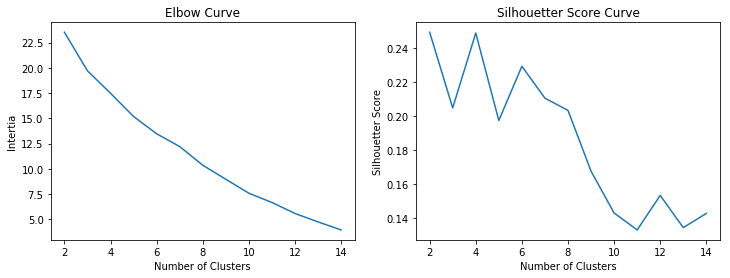

In [42]:
sil = []
inertia = []
for k in range(2,15):
    km = KMeans(n_clusters=k, random_state = 0).fit(cdmx_n) 
    y_pred = km.predict(cdmx_n)
    inertia.append((k, km.inertia_))
    sil.append((k, metrics.silhouette_score(cdmx_n, y_pred)))
fig, ax = plt.subplots(1,2, figsize=(12,4))# Plotting Elbow Curve
x_iner = [x[0] for x in inertia]
y_iner  = [x[1] for x in inertia]
ax[0].plot(x_iner, y_iner)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Intertia')
ax[0].set_title('Elbow Curve')# Plotting Silhouetter Score
x_sil = [x[0] for x in sil]
y_sil  = [x[1] for x in sil]
ax[1].plot(x_sil, y_sil), ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouetter Score'), ax[1].set_title('Silhouetter Score Curve')

Our silhouette scores are too low (meaning that clusters are too close to one another), and the elbow isn't very defined. Using only altitude and pIndex, we get:

Text(0.5,1,'Silhouetter Score Curve')

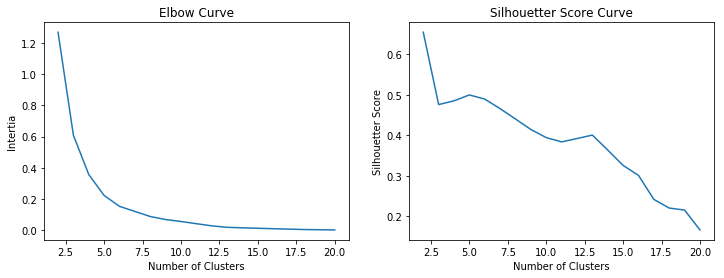

In [43]:
sil = []
inertia = []

subset = ['pIndex', 'Altitude']

for k in range(2,21):
    km = KMeans(n_clusters=k, random_state = 0)
    km.fit(cdmx_n[subset]) 
    y_pred = km.predict(cdmx_n[subset])
    inertia.append((k, km.inertia_))
    sil.append((k, metrics.silhouette_score(cdmx_n[subset], y_pred)))
fig, ax = plt.subplots(1,2, figsize=(12,4))# Plotting Elbow Curve
x_iner = [x[0] for x in inertia]
y_iner  = [x[1] for x in inertia]
ax[0].plot(x_iner, y_iner)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Intertia')
ax[0].set_title('Elbow Curve') # Plotting Silhouetter Score
x_sil = [x[0] for x in sil]
y_sil  = [x[1] for x in sil]
ax[1].plot(x_sil, y_sil)
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouetter Score')
ax[1].set_title('Silhouetter Score Curve')

This is better! After clustering, we can analyze which variables have an effect on pIndex and which don't. Here, we will use 4 clusters, since the elbow at 2  clusters is too high in its graph; also, 5 clusters leave us with 2 samples in one of the clusters, and that's not enough to determine correlations.

### Analysis: kmeans clustering with 4 clusters and subset 'pIndex', 'Altitude':

In [44]:
x = cdmx_n[subset]
kmeans = KMeans(n_clusters = 4, random_state=0).fit(x)
print(np.unique(kmeans.labels_, return_counts=True))

(array([0, 1, 2, 3], dtype=int32), array([ 8, 11,  3,  4]))


We have four clusters. One of them has 3 elements, and other has 4. Drawing conclusions from such small sample sizes using correlation analysis will prove difficult and dangerous, but we're going to try anyway. Worst case scenario, our correlations make no sense, and we conclude that this is not the correct method to study this particular case; best case scenario, our correlations make a lot of sense, and we're able to explain them. Either way, results are results. Let's carry on and see our clusters:

In [45]:
cluster_map = deleg.copy()
cluster_cdmx_n = x.copy()

#Add clusters to cluster_map, to cluster_cdmx, and cluster_cdmx_n
if not ('Cluster' in cluster_map.columns):
    cluster_map.insert(0, 'Cluster', kmeans.labels_)
if not ('Cluster' in cluster_cdmx_n.columns):
    cluster_cdmx_n.insert(0, 'Cluster', kmeans.labels_)

cluster_map.head()

,Cluster,Latitude,Longitude,Altitude
AJM,2,19.272100,-99.207658,2619
ATI,3,19.576963,-99.254133,2341
BJU,0,19.371612,-99.158969,2250
CCA,3,19.326200,-99.176100,2280
CHO,1,19.266948,-98.886088,2253


In [46]:
# set color scheme for the clusters
colors_array = ['#ff3300', 'orange', '#00cc00', '#3366ff']

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_map['Latitude'], cluster_map['Longitude'], cluster_map.index, 
                                  cluster_map['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        #popup=label,
        color= colors_array[cluster],
        fill=True,
        fill_color= colors_array[cluster],
        icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt">%s</div>' % "sdfasdf"),
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

Beautiful. 

<hr>
<h1 align='center'> 5. Results and discussion <h1> <a name="results"></a>
<hr>

We shall now examine our clusters, first visually, and then statistically.

In [47]:
clusters = len(np.unique(kmeans.labels_))
c = np.zeros(clusters, dtype = object) # define array of clusters

for i in range(clusters):
    c[i] = cdmx_n.loc[cluster_cdmx_n['Cluster'] == i, :]

In [48]:
pd.set_option('display.max_columns', None)
global_columns = cdmx_n.columns

In [49]:
# this function generates a colormap from the data in df. 
# it can also be used to draw a correlation matrix,
# we just need to pass the names of the rows and columns,
# which should be the same, and a numpy array that corresponds
# to those rows and columns.

def color_map(df, row_labels, col_labels):
    df = df.T
    fig, ax = plt.subplots()
    im = ax.pcolor(df, cmap='RdBu')

    #move ticks and labels to the center
    ax.set_xticks(np.arange(df.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(df.shape[0]) + 0.5, minor=False)

    #insert labels
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(col_labels, minor=False)

    #rotate label if too long
    plt.xticks(rotation=90)

    fig.set_size_inches(7, 5.5)
    fig.colorbar(im)
    plt.show()

In [50]:
# this function generates a correlation matrix. It also multiplies 
# the correlation coefficients by a factor of their respective
# p values. This generates a weighted correlation matrix which
# hides or weakens the effect of any correlation coefficient with
# a p value higher than 0.05.

def correlation_matrix_dataframe(df, switch):
    length = len(df.columns)
    cmatrix = np.zeros((length, length))
    
    for i, row in enumerate(df.columns):
        correlations = pearson_correlations(df, row)
        for j in range(i + 1, len(correlations)):
            coefficient = correlations[j, 1]
            p_value = correlations[j, 2]
            
            if (p_value > 0.05) & (switch):
                p_factor = 1./(10 + p_value - 0.05) # masking high p-valued correlations
            else:
                p_factor = 1.
            
            cmatrix[i, j] = coefficient * p_factor
            cmatrix[j, i] = coefficient * p_factor

    np.fill_diagonal(cmatrix, 1.0)
    
    return cmatrix

### Cluster 0 

In [51]:
c[0]

,pIndex,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,Buildings & Offices,Hotels & Hostels,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
BJU,0.847470,0.256198,0.040641,0.113862,0.044154,0.496257,0.994511,0.165441,1.000000,0.683333,0.0,0.6,0.166667,0.181818,0.0,0.0,0.666667,0.0,0.928571,1.000,0.0,0.266667,0.0
CUT,0.706593,0.351886,0.021723,0.106789,0.025036,0.379847,0.979027,0.189338,0.068182,0.083333,0.0,0.2,0.333333,0.000000,1.0,0.0,0.333333,0.0,0.000000,0.375,0.5,1.000000,0.0
LPR,0.741839,0.440067,0.028166,0.109363,0.011614,0.337304,0.958139,0.261029,0.204545,0.016667,0.0,0.0,0.000000,0.000000,0.0,0.0,0.500000,0.0,0.142857,0.250,0.0,0.000000,0.0
MER,0.622147,0.290442,0.042524,0.107401,0.023314,0.385396,0.966489,0.156250,0.590909,0.650000,0.0,0.0,0.500000,1.000000,1.0,0.0,0.500000,0.5,0.285714,0.125,0.5,0.066667,0.0
SAG,0.645533,0.295999,0.028343,0.093548,0.012488,0.429552,0.969134,0.148897,0.136364,0.333333,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.285714,0.000,0.0,0.000000,0.0
TLA,0.616621,0.317312,0.038944,0.090505,0.036439,0.369252,0.959923,0.277574,0.431818,1.000000,0.0,0.2,0.333333,0.000000,0.0,0.0,0.166667,0.0,0.285714,0.250,0.5,0.000000,0.0
VIF,0.607153,0.227209,0.022628,0.089884,0.034898,0.458350,0.973940,0.150735,0.068182,0.233333,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.125,0.0,0.066667,0.0
XAL,1.000000,0.370503,0.040105,0.081705,0.021105,0.520247,1.000000,0.000000,0.159091,0.083333,0.0,0.0,0.000000,0.090909,0.0,0.0,0.333333,0.0,0.142857,0.000,0.0,0.000000,1.0


These stations report the highest pollution. Understandably, the industrial category has a very strong, positive influence on pollution here, as the only station with a factory nearby has the highest pIndex out of all the stations in the dataset; however, we have to consider that this is one of the caveats of using extremely small sized sets of samples: every individual sample will have an enormous effect on whatever statistics we derive. Before we're content with our confirmation that industries pollute, we should see every correlation in our cluster. 

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


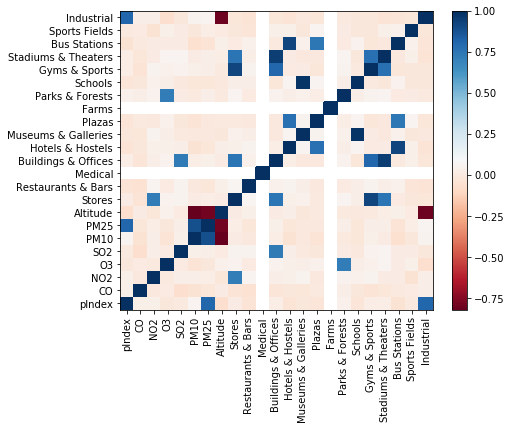

In [52]:
color_map(correlation_matrix_dataframe(c[0], True), c[0].columns, global_columns)

The Industrial variable has a strong, negative correlation to altitude, and altitude has strong, negative correlations with PM25 and PM10; PM25 has a strong, positive correlation to pIndex. We can conclude that the Industrial variable is indeed strongly correlated to pIndex, but not by causation, but by association, since a low altitude, in this particular case, is associated both with the presence of a soap factory and PM25, which is strongly correlated to pIndex. If we had more than one instance of the Industrial variable in this cluster, we could analyze this further. Other than that, there are no other venue types that can be correlated to pIndex. Stores can be correlated to NO<sub>2</sub> and Buildings & Offices can be correlated to SO<sub>2</sub>, but their regression plots tell us that, maybe, only the first of the two correlations is valid.

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


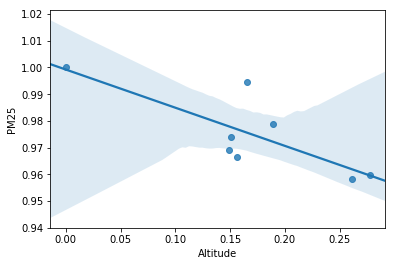

In [53]:
y = 'PM25'
x = 'Altitude'
sns.regplot(x = x, y = y, data=c[0][[x, y]])

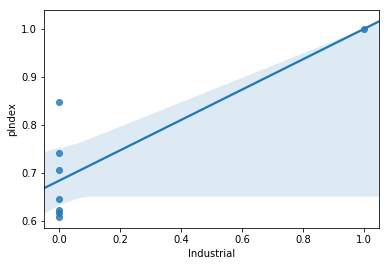

In [54]:
x = 'Industrial'
y = 'pIndex'
sns.regplot(x = x, y = y, data=c[0][[x, y]])

Almost no correlation between Industrial and pIndex.

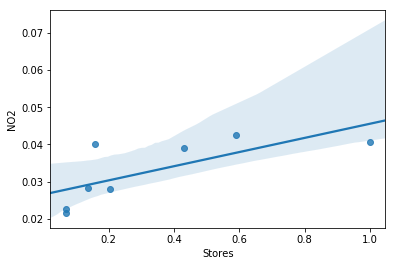

In [55]:
x = 'Stores'
y = 'NO2'
sns.regplot(x = x, y = y, data=c[0][[x, y]])

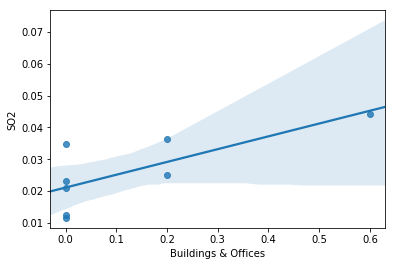

In [56]:
x = 'Buildings & Offices'
y = 'SO2'
sns.regplot(x = x, y = y, data=c[0][[x, y]])

### Cluster 1

In [57]:
c[1]

,pIndex,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,Buildings & Offices,Hotels & Hostels,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
CHO,0.366518,0.260306,0.020351,0.096488,0.000000,0.333582,0.957288,0.170956,0.022727,0.266667,0.0,0.2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.214286,0.000,0.0,0.000000,0.0
FAC,0.430544,0.299086,0.032952,0.119550,0.026691,0.269352,0.957341,0.255515,0.181818,0.700000,0.0,0.0,0.000000,0.000000,1.0,0.0,0.666667,0.0,0.357143,0.750,0.0,0.066667,0.0
GAM,0.393242,0.171998,0.030883,0.126453,0.002680,0.378658,0.972767,0.123162,0.522727,0.550000,0.0,0.2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.642857,0.125,0.5,0.000000,0.0
HGM,0.439562,0.254764,0.037537,0.113954,0.021208,0.315251,0.967460,0.136029,0.613636,0.800000,0.0,0.0,0.333333,0.272727,1.0,0.0,0.000000,0.5,0.214286,0.500,0.0,0.000000,0.0
IZT,0.486104,0.289204,0.036225,0.108617,0.015849,0.325170,0.961974,0.143382,0.431818,0.950000,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.357143,0.125,0.0,0.066667,0.0
LLA,0.469941,0.285730,0.030699,0.098515,0.021647,0.333786,0.957334,0.128676,0.477273,0.133333,0.0,0.4,0.000000,0.090909,0.0,0.0,0.000000,0.0,0.142857,0.125,0.0,0.066667,0.0
NEZ,0.568160,0.292895,0.028917,0.119268,0.018692,0.345143,0.979488,0.137868,0.204545,0.383333,0.0,0.0,0.000000,0.000000,0.0,0.5,0.000000,0.0,0.428571,0.000,0.0,0.000000,0.0
TAH,0.471490,0.212784,0.015414,0.138732,0.002397,0.388521,0.970757,0.251838,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.0,0.500000,0.0,0.571429,0.250,0.0,0.133333,0.0
TLI,0.391678,0.293454,0.032427,0.118381,0.048196,0.261401,0.928677,0.281250,0.159091,0.133333,0.0,0.2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.071429,0.250,0.0,0.000000,0.5
UAX,0.423437,0.236550,0.022073,0.110762,0.006811,0.365995,0.958677,0.158088,0.568182,0.616667,0.0,0.6,0.000000,0.000000,0.0,1.0,0.666667,0.0,0.500000,0.125,0.0,0.000000,0.0


This cluster represents the moderately polluted areas. This is an understatement, however: let's not lose sight of PM25, which is high accross every cluster, well into the "very bad" IMECA level. Let's see the correlations between variables. 

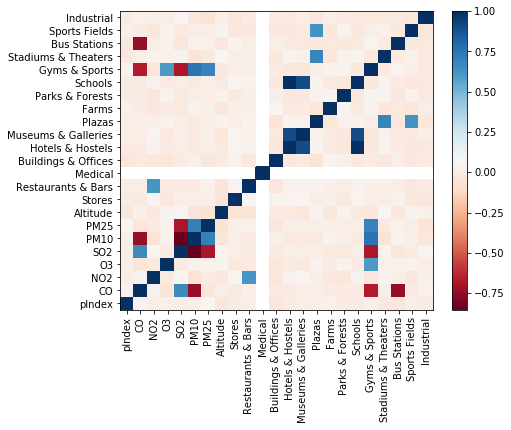

In [58]:
color_map(correlation_matrix_dataframe(c[1], True), c[1].columns, global_columns)

Here, we have bus stations only near the GAM station, and this seems to be negatively correlated to CO; however, this is the same case as in the Industrial variable on cluster 0. We will not trust that correlation. Fortunately, there are restaurants & bars, and gyms & sports venues near every station in this cluster, and those two variables are correlated to different pollutants (even if not directly to pIndex). We can inspect some regression plots, then:

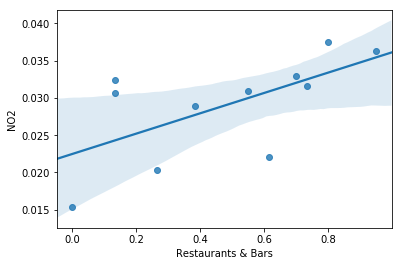

In [59]:
x = 'Restaurants & Bars'
y = 'NO2'
sns.regplot(x = x, y = y, data=c[1][[x, y]])

Even though the relationship between restaurants & bars and NO2 might not be linear (it looks like a sine wave), it's clearly positive. One source of NO2 is the combustion of fossil fuels, such as coal, gas and oil. Having many places to eat, in a place such as GMX, guarantees the existence of many taco places and burger joints. This correlation, then, could be more of a causation.

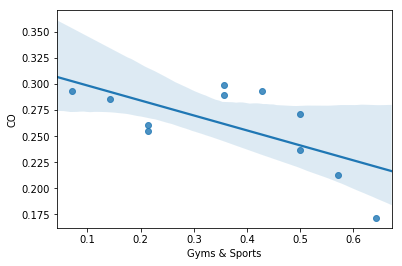

In [60]:
x = 'Gyms & Sports'
y = 'CO'
sns.regplot(x = x, y = y, data=c[1][[x, y]])

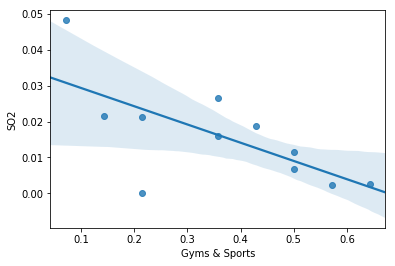

In [61]:
x = 'Gyms & Sports'
y = 'SO2'
sns.regplot(x = x, y = y, data=c[1][[x, y]])

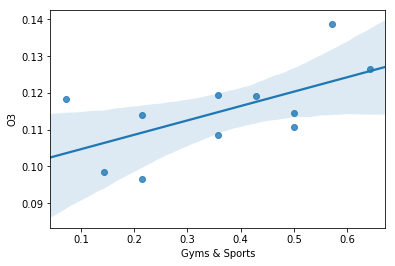

In [62]:
x = 'Gyms & Sports'
y = 'O3'
sns.regplot(x = x, y = y, data=c[1][[x, y]])

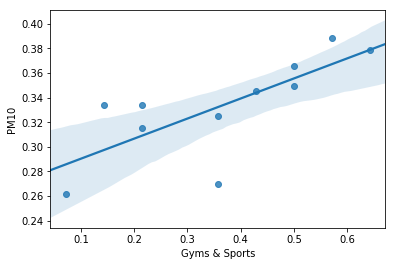

In [63]:
x = 'Gyms & Sports'
y = 'PM10'
sns.regplot(x = x, y = y, data=c[1][[x, y]])

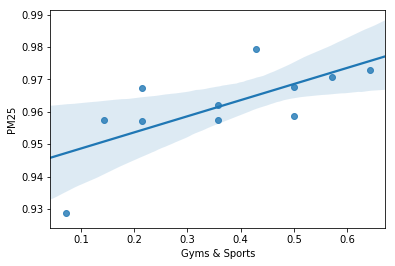

In [64]:
x = 'Gyms & Sports'
y = 'PM25'
sns.regplot(x = x, y = y, data=c[1][[x, y]])

Every plot here behaves kind of like a wave, much like the Restaurants & Bars - NO<sub>2</sub> plot. However, in these two last plots, it looks like some specific points are tilting the correlations to make them seem stronger than they really are. For example, in the last plot, if we took the first point away, the correlation would look extremely weak, or even nonexistent. I would argue that the gyms & sports venues are only correlated to CO, SO<sub>2</sub> and O<sub>3</sub>, since air quality is directly related to the amount of exercise a person can do, and thus, areas with lower pollution are more suited for exercise. As for the wave-like behavior, more data is needed to explain it.

### Cluster 2 

In [65]:
c[2]

,pIndex,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,Buildings & Offices,Hotels & Hostels,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,0.063152,0.160576,0.014453,0.162434,0.017040,0.245542,0.892866,0.843750,0.045455,0.25,0.0,0.2,0.0,0.0,0.0,0.0,0.166667,0.0,0.285714,0.000,0.0,0.000000,0.0
CUA,0.303390,0.294866,0.023970,0.109620,0.012078,0.224163,0.966879,1.000000,0.431818,0.40,0.0,0.4,0.5,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000,0.0,0.200000,0.0
SFE,0.000000,0.153873,0.025254,0.122352,0.007593,0.246152,0.901235,0.806985,0.295455,0.60,0.0,1.0,1.0,0.0,0.0,0.0,0.166667,0.0,0.714286,0.125,0.5,0.066667,0.0


This cluster includes the stations with the highest altitude and the least pollution - except for the CUA station. There are only three stations, so we need to be extra wary of what our statistics tell us.

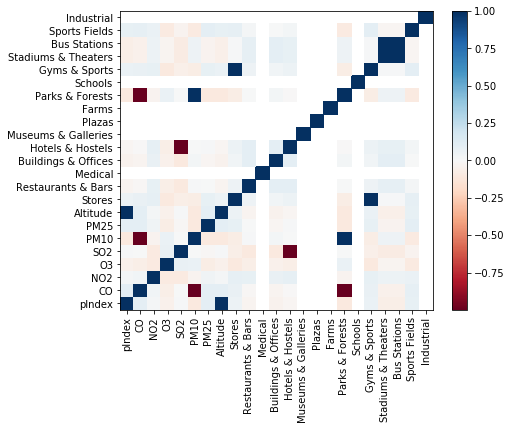

In [66]:
color_map(correlation_matrix_dataframe(c[2], True), c[2].columns, global_columns)

The Parks & Forests variable seems to have a negative correlation with CO. Indeed, it is known that plants use CO for many processes (Bidwell 1972, Wang 2016), which could actually mean that this correlation is a causation. The correlations are consistent, too: Parks & Forests is negatively correlated to CO and positively correlated to PM10, and PM10 is negatively correlated to CO. The link between these three variables could be altitude. The higher you go, the less protection you have from sunlight. Sunlight catalyzes many chemical reactions, some of which could be forming PM10 from CO. However, we do not have enough data to confirm this.

### Cluster 3

In [67]:
c[3]

,pIndex,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,Buildings & Offices,Hotels & Hostels,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
ATI,0.206851,0.208255,0.024514,0.097785,0.024297,0.314077,0.906926,0.332721,0.000000,0.150000,0.0,0.2,0.000000,0.000000,0.0,0.0,0.333333,0.0,0.285714,0.000,0.0,0.133333,0.0
CCA,0.214846,0.211194,0.026990,0.121028,0.011395,0.292734,0.917127,0.220588,0.090909,0.800000,0.0,0.0,0.000000,0.181818,1.0,0.0,0.500000,1.0,0.642857,0.875,1.0,0.066667,0.0
MGH,0.220160,0.266887,0.034691,0.099863,0.020461,0.245423,0.916211,0.378676,0.272727,0.850000,1.0,0.0,0.166667,1.000000,1.0,0.0,1.000000,0.0,0.571429,0.125,0.0,0.000000,0.0
PED,0.061857,0.173215,0.023902,0.152341,0.010437,0.235708,0.896560,0.305147,0.590909,0.433333,0.0,0.2,0.000000,0.090909,1.0,0.5,0.333333,0.0,0.857143,0.000,0.0,0.066667,0.0


Cluster 3 is yet another small-sized set. Stations here have the second places in both altitude and pIndex. 

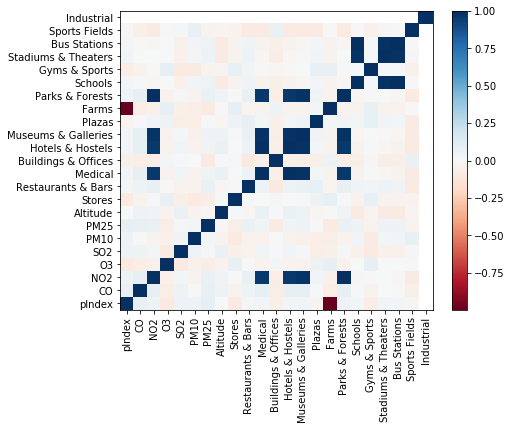

In [68]:
color_map(correlation_matrix_dataframe(c[3], True), c[3].columns, global_columns)

The variables Farms and Medical occur only one station at a time, which is why we should ignore their correlations. The only variables that we can trust are really correlated to NO<sub>2</sub> are Parks & Forests and Museums & Galleries. If we look at their regression plots:

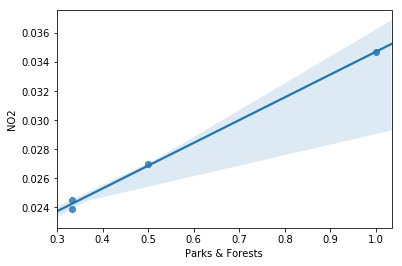

In [69]:
y = 'NO2'
x = 'Parks & Forests'
sns.regplot(x = x, y = y, data=c[3][[x, y]])

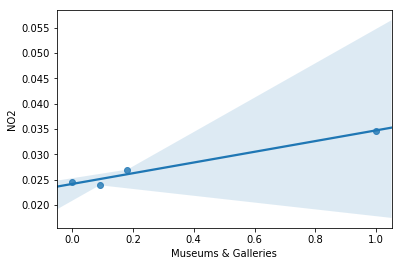

In [70]:
y = 'NO2'
x = 'Museums & Galleries'
sns.regplot(x = x, y = y, data=c[3][[x, y]])

we can see a nice, linear correlations. The mechanism for which museums and galleries would be (weakly) correlated to a NO<sub>2</sub> increase could be attributed to them being places that many people visit all year long. Some of the most iconic museums, galleries and theaters are congregated here, including the National Auditorium. The same can be said about the Parks & Forests variable. The MGH station is located near Chapultepec, a forest which is a major cultural asset in Mexico City. More can be said about NO<sub>2</sub> and forests. A sweden paper (Grundström 2014) suggests that urban forests have a very small effect in reducing NO<sub>2</sub> and no effect on O<sub>3</sub>, while research conducted on the USA (Yli-Pelkonen 2017) suggests that O<sub>3</sub> but not NO<sub>2</sub> is reduced by urban trees. Another study, conducted in the Netherlands (Dorsey 2004) found that soils in forests can be a net source of reactive NO. NO can be oxidized to NO<sub>2</sub> by reacting with O<sub>3</sub> and other chemical species. From the varying results of research in different countries, we see that urban trees have different effects depending on their specific contexts and species. It could be the case that the Chapultepec forest is actually one of those NO producing forests. Specific studies should be conducted before reaching this conclusion, but we are well justified in suspecting this.

### GMX

Now let's see the correlation matrix for GMX as a whole:

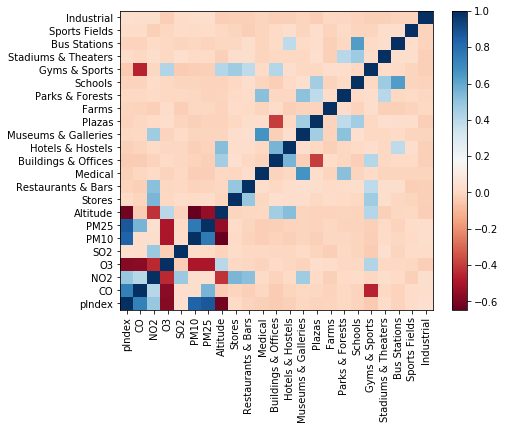

In [71]:
color_map(correlation_matrix_dataframe(cdmx_n, True), global_columns, global_columns)

We see some familiar correlations, such as the negative correlation between Gyms & Sports and CO that we saw in cluster 1, or the positive correlation between Museums & Galleries and NO<sub>2</sub> that we saw in cluster 3. However, most of the other correlations between venues and pollutants are nowhere to be seen. 

<hr>
<h1 align='center'> 6. Conclusions <h1> <a name="conclusion"></a>
<hr>

While some effects cannot be seen in the complete GMX dataset, they can be seen once we partition our data into smaller datasets. Some of these effects include:

<ul>
    <li>In the most polluted, lowest altitude regions (cluster 0), the presence of a soap factory nearby the XAL station was strongly correlated with pIndex. We cannot directly conclude that this factory is the culprit, since we do not have many factories in our data, and thus, this station is an outlier inside its own cluster. </li>
    <li>In regions with moderate pollution and low altitude (cluster 1), having many places to eat is correlated to higher NO<sub>2</sub> concentrations, and having places where you can exercise is correlated to lower SO<sub>2</sub> and CO concentrations, and higher O<sub>3</sub> concentrations.</li>
    <li>About clusters 2 and 3, I suspect that urban forests play different roles. In cluster 2, we see a negative correlation between Parks & Forests and CO. In cluster 3, we see a positive correlation between NO<sub>2</sub> and Parks & Forests. While we cannot be sure of the inner workings behind these observations, these results hint at what other studies already say: that urban forests behave one way here, and a different way over there. Specific research should have to be done to address this.</li>
</ul>

Also, because of the presence of wind, there might be a correlation between venue and station positionings. If we look at our clustering map, we see that the most polluted areas are to the northeast of GMX, and the least polluted to the southwest. This model doesn't consider winds, but our clustering suggests that it should, which is an important conclusion by itself.

<hr>
<h1 align='center'> 7. Final remarks <h1> <a name="remarks"></a>
<hr>

Through our clustering analysis, we learned about some correlations that were invisible when looking at the whole dataset. This is a double-edged sword, because reducing the size of the datasets will result in more drastic effects being observed, but less generalization power. Ideally, I would have liked to work with a much bigger dataset. Even a hundred stations would have been enough, but after cleaning the data, we ended up discarding about 12 stations, and only 26 remained. Even so, because we clustered our stations using educated criteria, we can trust that any phenomenon observed (such as the positive correlation between forests and NO<sub>2</sub>) is well justified in arising suspicion. While our datasets were too small to conduct comfortable statistics, those statistics are still statistics, and can be valuable when interpreted under the right context.

When I get the chance, I would like to repeat this experiment incorporating distances from every venue to every station, since pollution is known to travel by wind. It isn't static, as this model wordlessly implies, and the pollution from some venues could be impacting on venues far away. This would also solve many NaN problems, since every station would have at least a tiny amount associated to each type of venue, which would help the correlation analysis immensely. 

Finally, I hope you had as much fun reading this as I had writing it. Thank you.